In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import copy

In [2]:
label_def_similar_shapes = {'background': 0, 'f_s20_40_20_40_B_G': 1, 'm20_100': 2, 'm20_30': 3, 'r20': 4, 
             'bearing_box': 5, 'bearing': 6, 'axis': 7, 'distance_tube': 8, 'motor': 9, 
             'container': 10, 'em_01': 11, 'em_02': 12}

label_def_full = {'background': 0, 'f20_20_B': 1, 's40_40_B': 2, 'f20_20_G': 3, 's40_40_G': 4,  
             'm20_100': 5, 'm20': 6, 'm30': 7, 'r20': 8, 'bearing_box_ax01': 9, 'bearing': 10, 'axis': 11, 
             'distance_tube': 12, 'motor': 13, 'container_box_blue': 14, 'container_box_red': 15, 
             'bearing_box_ax16': 16, 'em_01': 17, 'em_02': 18}

label_def_size_invariant = {'background': 0, 'f_s20_40_20_40_B': 1, 'f_s20_40_20_40_G': 2,
                            'm20_100': 3, 'm20_30': 4, 'r20': 5, 'bearing_box': 6, 
                            'bearing': 7, 'axis': 8, 'distance_tube': 9, 'motor': 10, 'container_box_blue': 11, 
                            'container_box_red': 12, 'em_01': 13, 'em_02': 14}

label_def_binary = {'background': 0, 'foreground': 1}

variant_to_label_def = {'full': label_def_full, 'binary': label_def_binary,
                                     'similar_shapes': label_def_similar_shapes, 
                                     'size_invariant': label_def_size_invariant}

In [3]:
class DataAnalysis():
    
    def __init__(self, VARIANT='full', 
                 LABEL_PATH='./objects/real_augmented/training/size_invariant'):
        
        self.variant = VARIANT
        self.label_path = LABEL_PATH
        self.label_def = variant_to_label_def[VARIANT]
        
        file_paths = self.read_labels()
        self.image_to_cls_to_pixelCount = self.initialize_data_dict()
        self.total_pixels = self.get_total_pixels(file_paths)
        self.populate_data_dict(file_paths)
    
    def read_labels(self):
            
        return [os.path.join(self.label_path, file) for file in
               os.listdir(self.label_path)]
    
    def initialize_data_dict(self):
        
        image_to_cls_to_pixelCount = {}
        cls_to_pixelCount = {key:0 for key in range(len(self.label_def))}
        for file in os.listdir(self.label_path):
            image_to_cls_to_pixelCount[file] = cls_to_pixelCount.copy()
            
        return image_to_cls_to_pixelCount
    
    def get_total_pixels(self, file_paths):
        
        img_dimension = cv2.imread(file_paths[0], 0).shape
        return img_dimension[0]*img_dimension[1]*len(file_paths)
    
    def populate_data_dict(self, file_paths):
        
        for file in file_paths:
            img = cv2.imread(file, 0)
            clses = np.unique(img)
            img_name = file.split('/')[-1]

            for cls in clses:      
                self.image_to_cls_to_pixelCount[img_name][cls] = np.shape(
                                                        np.argwhere(img==cls))[0]

            if sum(self.image_to_cls_to_pixelCount[img_name].values()
                                      ) != img.shape[0]*img.shape[1]:
                raise ValueError('Not all pixels have been counted...')
                
    def get_cls_to_percentage(self):
        
        cls_to_percentage = {key:0 for key in self.label_def.keys()}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            for key in cls_to_percentage.keys():
                cls_to_percentage[key] += count_dict.get(self.label_def[key], 0)

        return {key:round((value/self.total_pixels)*100, 4) for key, value in 
                                            cls_to_percentage.items()}
    
    def plot_cls_to_x(self, cls_to_x, y_label, ignore_background=False,
                      cls_to_x_validation=None, cls_to_x_test=None, 
                      bar_width=0.3, set_fonts=17):
        
        cls_to_x = copy.deepcopy(cls_to_x)
        cls_to_x_validation = copy.deepcopy(cls_to_x_validation)
        cls_to_x_test = copy.deepcopy(cls_to_x_test)
        
        figure = plt.figure(figsize=(15, 5))
    
        x = np.array(list(self.label_def.values()))
        x_ticks = np.empty(len(self.label_def), dtype = str)

        for label in self.label_def.keys():
                x_ticks[self.label_def[label]] = label

        if ignore_background:
            cls_to_x.pop('background', None)
            if cls_to_x_validation is not None:
                cls_to_x_validation.pop('background', None)
            if cls_to_x_test is not None:
                cls_to_x_test.pop('background', None)
            x = x[-len(cls_to_x):]
            x_ticks = x_ticks[-len(cls_to_x):]

        cmap = plt.cm.get_cmap('Paired')
        
        plt.bar(x, cls_to_x.values(), width=bar_width, 
                align='center', color=cmap(0.2), zorder=3, label='TrainingSet')
        if cls_to_x_validation is not None:
            plt.bar(x + bar_width, cls_to_x_validation.values(), 
                    width=bar_width, align='center', color=cmap(0.5), 
                    zorder=3, label='ValidationSet')
        if cls_to_x_test is not None:
            plt.bar(x - bar_width, cls_to_x_test.values(), 
                    width=bar_width, align='center', color=cmap(0.7), 
                    zorder=3, label='TestSet')

        plt.xlabel('class name', fontsize=set_fonts)
        plt.ylabel(y_label, fontsize=set_fonts)
        plt.title('VARIANT: {}'.format(self.variant),
                 fontsize=set_fonts)
        plt.xticks(x, cls_to_x.keys(), rotation=80)
        plt.grid(zorder=0, axis='y')
        plt.tick_params(axis='both', which='major', labelsize=set_fonts)
        plt.legend(fontsize=set_fonts)
        plt.show()
        
    def get_cls_to_weight(self, cls_to_percentage, set_background_weight=None):
        
        cls_to_weight = {key: round(1/(100*value),4)
                         for key, value in cls_to_percentage.items()}

        normalizer = sum(cls_to_weight.values()) - cls_to_weight['background']
        
        if set_background_weight is None:
            background_weight = cls_to_weight['background']  
        else:
            background_weight = set_background_weight

        cls_to_weight = {key: round(value*(1 - background_weight)/normalizer, 4) 
                         if key is not 'background'
                        else background_weight for key, value in cls_to_weight.items()}

        if abs(1. - sum(cls_to_weight.values())) > 1e-3:
            raise ValueError (
                'The sum of weights is {}... The weights have not been normalized...'.
                format(sum(cls_to_weight.values())))

        return cls_to_weight
    
    def get_weight_list(self, cls_to_weight):
        
        weight_list = np.zeros(len(self.label_def))
        for label in self.label_def.keys():
            weight_list[self.label_def[label]] = cls_to_weight[label]

        return list(weight_list)
    
    def get_cls_to_count(self, cls_to_weight):
        
        cls_to_count = {key:0 for key in range(len(self.label_def))}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            cls_to_count = {key: value + 1 if count_dict[key]!=0 
                            else value for key, value in cls_to_count.items()}
            
        cls_to_count = {key: cls_to_count[self.label_def[key]] for 
                        key in cls_to_weight.keys()}
            
        return cls_to_count

In [4]:
analyzer_tr_full = DataAnalysis(VARIANT='full', LABEL_PATH='./objects/real_augmented/training/full')
analyzer_va_full = DataAnalysis(VARIANT='full', LABEL_PATH='./objects/real_augmented/validation/full')
analyzer_te_full = DataAnalysis(VARIANT='full', LABEL_PATH='./objects/real_augmented/test/full')

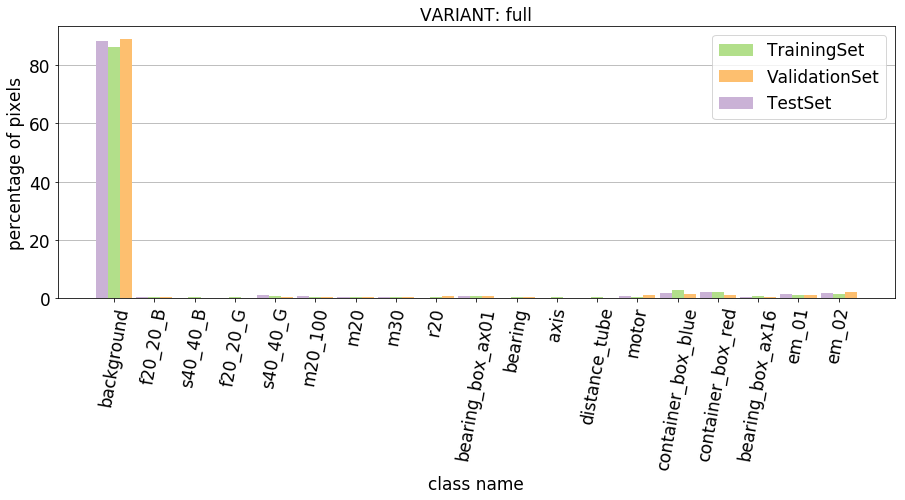

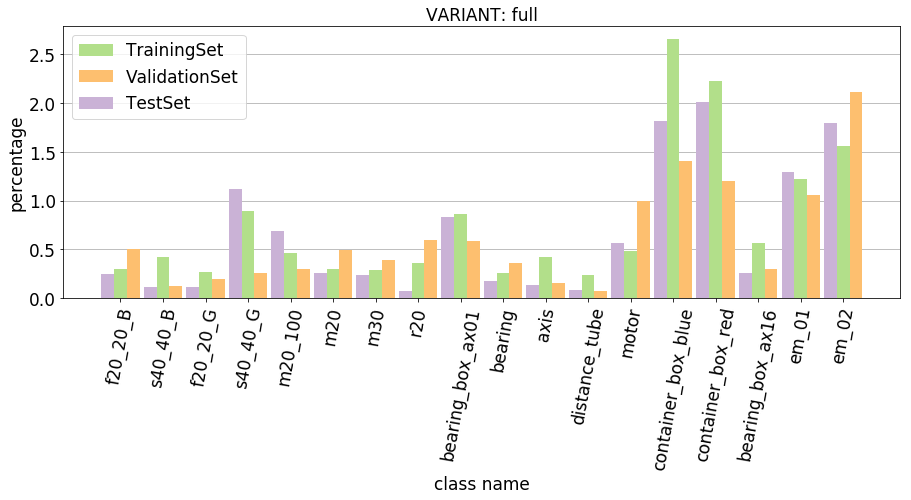

In [5]:
cls_to_percentage_tr = analyzer_tr_full.get_cls_to_percentage()
cls_to_percentage_va = analyzer_va_full.get_cls_to_percentage()
cls_to_percentage_te = analyzer_te_full.get_cls_to_percentage()

analyzer_tr_full.plot_cls_to_x(cls_to_percentage_tr, 'percentage of pixels', 
                               ignore_background=False, 
                               cls_to_x_validation=cls_to_percentage_va, 
                               cls_to_x_test=cls_to_percentage_te)

analyzer_tr_full.plot_cls_to_x(cls_to_percentage_tr, 'percentage', 
                               ignore_background=True, 
                               cls_to_x_validation=cls_to_percentage_va, 
                               cls_to_x_test=cls_to_percentage_te)

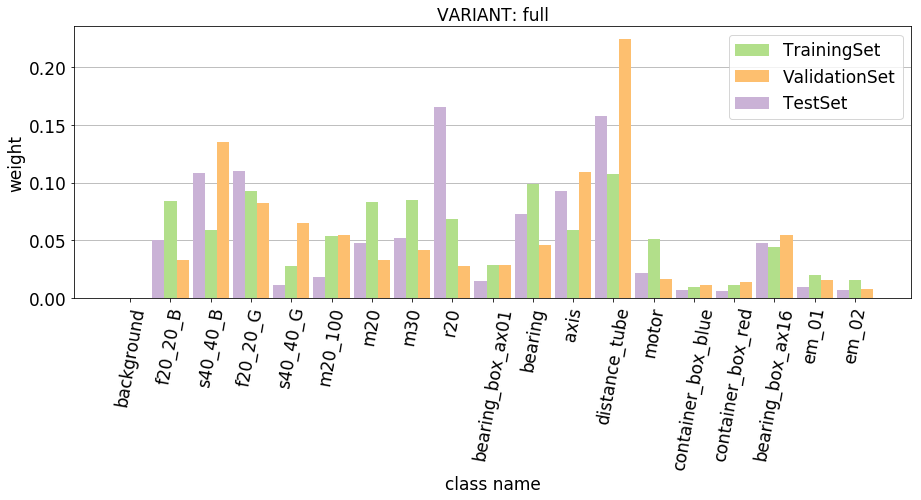

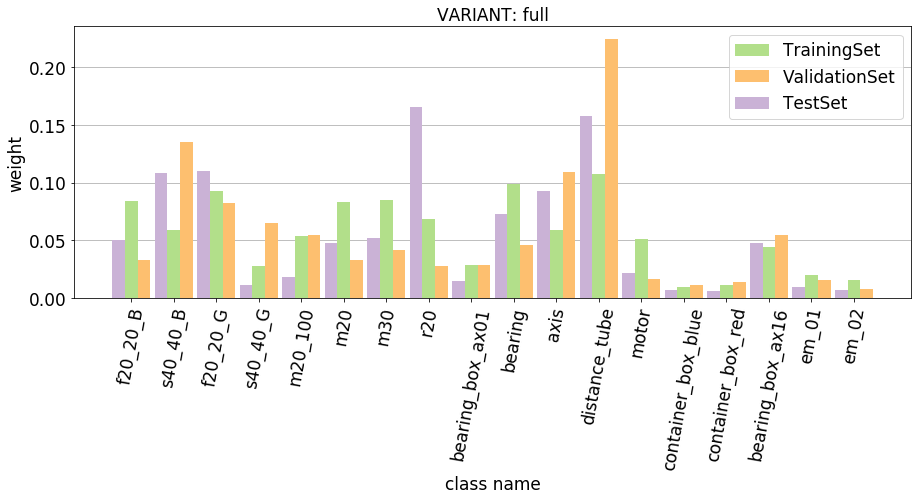

In [6]:
cls_to_weight_tr = analyzer_tr_full.get_cls_to_weight(cls_to_percentage_tr)
cls_to_weight_va = analyzer_va_full.get_cls_to_weight(cls_to_percentage_va)
cls_to_weight_te = analyzer_te_full.get_cls_to_weight(cls_to_percentage_te)

analyzer_tr_full.plot_cls_to_x(cls_to_weight_tr, 'weight', 
                               ignore_background=False, 
                               cls_to_x_validation=cls_to_weight_va, 
                               cls_to_x_test=cls_to_weight_te)

analyzer_tr_full.plot_cls_to_x(cls_to_weight_tr, 'weight', 
                               ignore_background=True, 
                               cls_to_x_validation=cls_to_weight_va, 
                               cls_to_x_test=cls_to_weight_te)

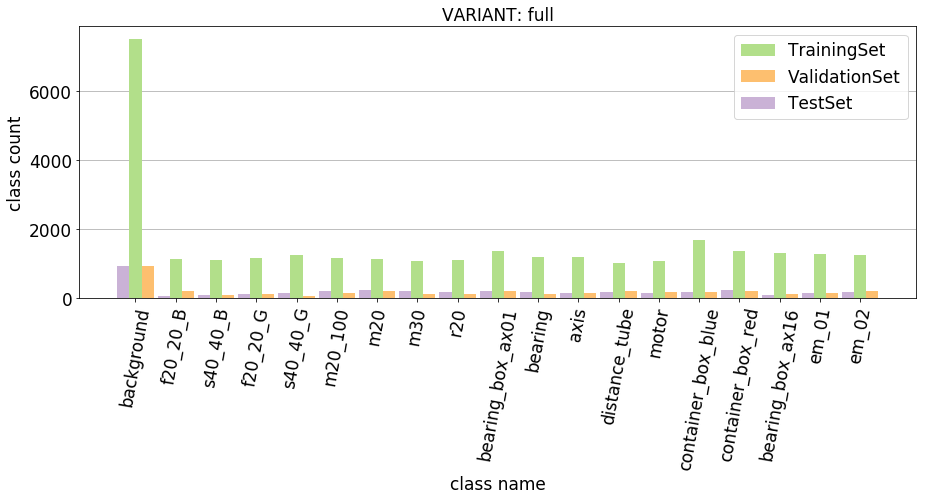

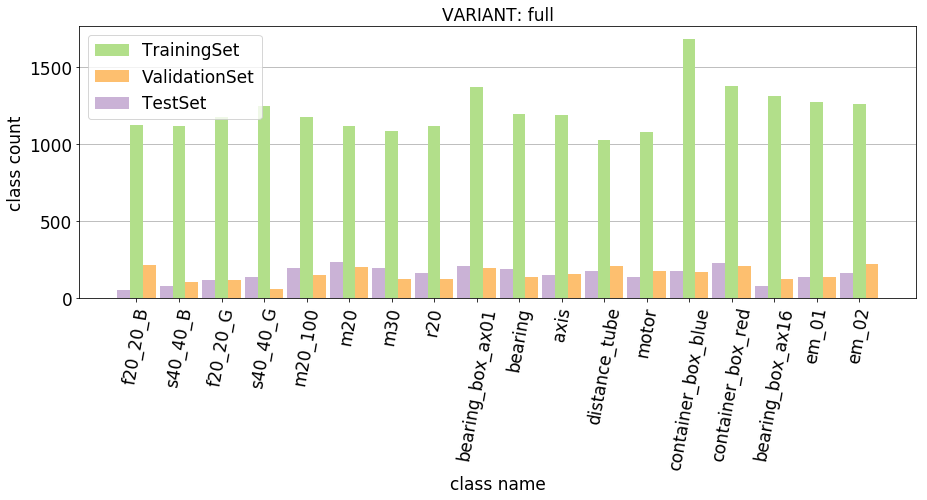

In [8]:
cls_to_count_tr = analyzer_tr_full.get_cls_to_count(cls_to_weight_tr)
cls_to_count_va = analyzer_va_full.get_cls_to_count(cls_to_weight_va)
cls_to_count_te = analyzer_te_full.get_cls_to_count(cls_to_weight_te)

analyzer_tr_full.plot_cls_to_x(cls_to_count_tr, 'class count', 
                               ignore_background=False, 
                               cls_to_x_validation=cls_to_count_va, 
                               cls_to_x_test=cls_to_count_te)

analyzer_tr_full.plot_cls_to_x(cls_to_count_tr, 'class count', 
                               ignore_background=True, 
                               cls_to_x_validation=cls_to_count_va, 
                               cls_to_x_test=cls_to_count_te)

In [ ]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [ ]:
analyzer = DataAnalysis(VARIANT='similar_shapes', LABEL_PATH='./objects/real_augmented/training/similar_shapes')

In [ ]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

In [ ]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

In [ ]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [ ]:
analyzer = DataAnalysis(VARIANT='size_invariant', LABEL_PATH='./objects/real_augmented/training/size_invariant')

In [ ]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

In [ ]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage, set_background_weight=0.3)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

In [ ]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [ ]:
analyzer = DataAnalysis(VARIANT='binary', LABEL_PATH='./objects/real_augmented/training/binary')

In [ ]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

In [ ]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

In [ ]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')